pipeline xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_pickle('composite_df.pkl')
df['time_until_reading_hr'] = 24 - df['time_until_reading_hr']
df_g = df.groupby(['day_id', 'st_code'])


kill reflectivity data below 12 dB, which is likely noise

In [4]:
# exp1 if cond else exp2
affected = ('refl_2000', 'refl_3000', 'refl_4000', 'refl_5000', 'refl_6000')
for col in affected:
    df[col].apply(lambda ref: 0 if ref < 12 else ref)


get simple means

In [5]:
df.columns

Index(['day_id', 'difphase_2000', 'difphase_3000', 'difphase_4000',
       'difphase_5000', 'difphase_6000', 'elev_m', 'expected_mm', 'gate_time',
       'lat', 'lon', 'r_dist_km', 'r_elev_delta_m', 'refl_2000', 'refl_3000',
       'refl_4000', 'refl_5000', 'refl_6000', 'st_code', 'time_until_reading',
       'time_until_reading_hr', 'velocity_2000', 'velocity_3000',
       'velocity_4000', 'velocity_5000', 'velocity_6000', 'xcorr_ratio_2000',
       'xcorr_ratio_3000', 'xcorr_ratio_4000', 'xcorr_ratio_5000',
       'xcorr_ratio_6000'],
      dtype='object')

In [6]:
to_df = []
dates = []
sensors = []
for k,grp in df_g:
    sensors.append(grp.st_code.iloc[0])
    dates.append(grp.gate_time.iloc[0])
    to_df.append(grp.mean())

df_mean = pd.DataFrame.from_dict(to_df)
df_mean['dates'] = pd.Series(dates)
df_mean['st_code'] = pd.Series(sensors)  

#drop negative snowfall (meltoff)
print(df_mean.shape)
df_mean = df_mean[df_mean.expected_mm > -40]
print(df_mean.shape)

# automatically drops non-numeric columns
X = df_mean.drop(['day_id','expected_mm', 'time_until_reading', 'time_until_reading_hr', 'dates', 'st_code'], axis=1)
y = df_mean['expected_mm'] #- df_mean['expected_mm'].min() +1

(723, 31)
(722, 31)


explore data

In [8]:
#check columns
df_mean.columns

Index(['day_id', 'difphase_2000', 'difphase_3000', 'difphase_4000',
       'difphase_5000', 'difphase_6000', 'elev_m', 'expected_mm', 'lat', 'lon',
       'r_dist_km', 'r_elev_delta_m', 'refl_2000', 'refl_3000', 'refl_4000',
       'refl_5000', 'refl_6000', 'time_until_reading', 'time_until_reading_hr',
       'velocity_2000', 'velocity_3000', 'velocity_4000', 'velocity_5000',
       'velocity_6000', 'xcorr_ratio_2000', 'xcorr_ratio_3000',
       'xcorr_ratio_4000', 'xcorr_ratio_5000', 'xcorr_ratio_6000', 'dates',
       'st_code'],
      dtype='object')

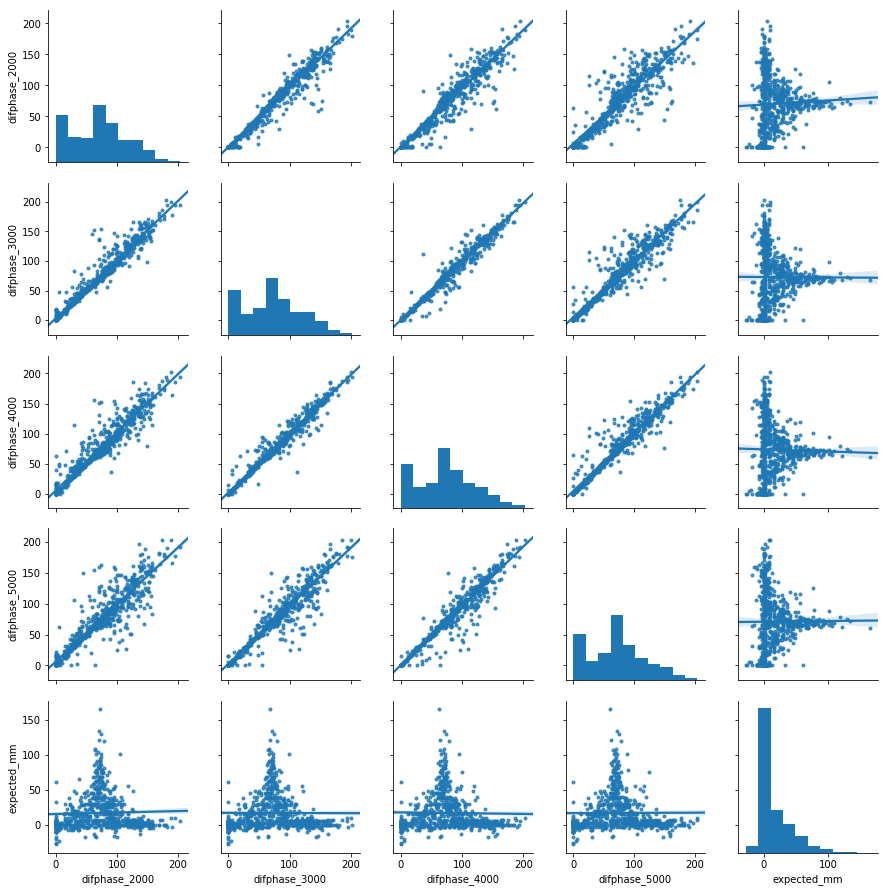

In [10]:
import seaborn as sns
cols = 'difphase_2000 difphase_3000 difphase_4000 difphase_5000 expected_mm'.split()
sns.pairplot(df_mean[cols], kind='reg', markers='.')
plt.show()

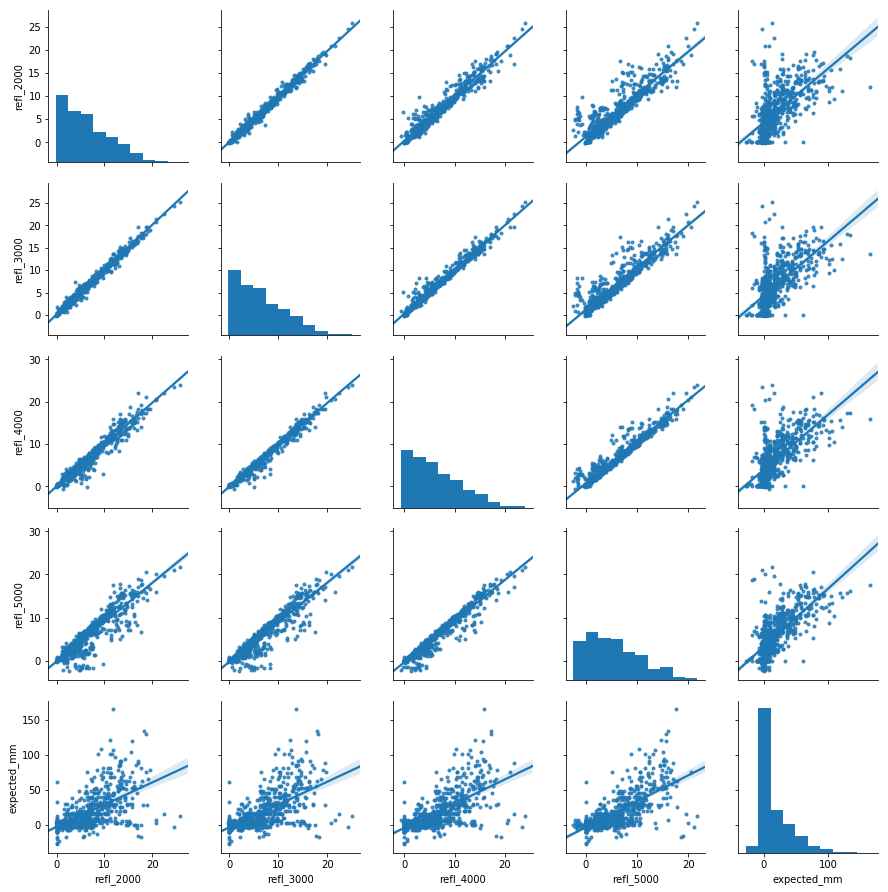

In [11]:
cols = 'refl_2000 refl_3000 refl_4000 refl_5000 expected_mm'.split()
sns.pairplot(df_mean[cols], kind='reg', markers='.')
plt.show()

start modeling

In [104]:
#check columns
X.columns

Index(['difphase_2000', 'difphase_3000', 'difphase_4000', 'difphase_5000',
       'difphase_6000', 'elev_m', 'lat', 'lon', 'r_dist_km', 'r_elev_delta_m',
       'refl_2000', 'refl_3000', 'refl_4000', 'refl_5000', 'refl_6000',
       'time_until_reading_hr', 'velocity_2000', 'velocity_3000',
       'velocity_4000', 'velocity_5000', 'velocity_6000', 'xcorr_ratio_2000',
       'xcorr_ratio_3000', 'xcorr_ratio_4000', 'xcorr_ratio_5000',
       'xcorr_ratio_6000', 'dates', 'st_code'],
      dtype='object')

In [106]:
X.iloc[0]

difphase_2000                        116.223
difphase_3000                        130.412
difphase_4000                        129.017
difphase_5000                        131.699
difphase_6000                        134.098
elev_m                               2882.25
lat                                  37.7034
lon                                 -119.165
r_dist_km                            162.404
r_elev_delta_m                       2808.13
refl_2000                            7.98757
refl_3000                            7.19889
refl_4000                            6.75812
refl_5000                            6.32166
refl_6000                            5.59859
time_until_reading_hr                     20
velocity_2000                        3.31161
velocity_3000                          3.313
velocity_4000                        3.31527
velocity_5000                        2.43694
velocity_6000                      -0.704667
xcorr_ratio_2000                    0.743999
xcorr_rati

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

In [13]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor


In [48]:
%%time

param_grid_xgb = {'n_estimators':   [80, 90, 100],
                  'n_jobs':         [-1],
                  'learning_rate':  [.05,.07,.1, .2], 
                  'subsample':      [.6, .7, .8],
                  'max_depth':      [3,4,5],
                  'reg_alpha':      [9,12,14],
                  'reg_lambda':     [16,18,22]}

models = {
    'xgbr': GridSearchCV(XGBRegressor(), param_grid=param_grid_xgb, cv=3, scoring='neg_mean_squared_error', verbose =1),
}
# add votingclassifier after param search
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

for m in models.keys():
    print('training ' + m)
    models[m].fit(X_train, y_train)
    y_pred_train = models[m].predict(X_train)
    y_pred = models[m].predict(X_test)

    print(models[m].best_estimator_)
    print('train mae: ', mean_absolute_error(y_train, y_pred_train))
    print('test mae:  ', mean_absolute_error(y_test, y_pred), '\n')


training xgbr
Fitting 3 folds for each of 972 candidates, totalling 2916 fits


[Parallel(n_jobs=1)]: Done 2916 out of 2916 | elapsed:  5.4min finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=80,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=14, reg_lambda=18, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)
train mae:  3.57268720667
test mae:   9.20247537 

CPU times: user 5min 12s, sys: 3.11 s, total: 5min 15s
Wall time: 5min 25s


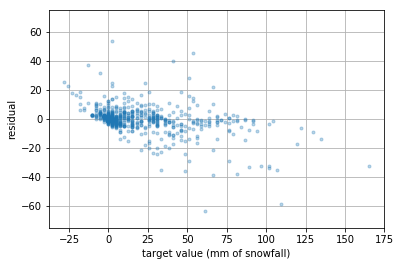

3.3872660517
8.98420609061


In [60]:
#xgbr = models['xgbr'].best_estimator_ 
# best with only positive snowfall
xgbr = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=90,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=8, reg_lambda=16, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

# best include meltoff
# xgbr = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=1, gamma=0, learning_rate=0.07, max_delta_step=0,
#        max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
#        n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
#        reg_alpha=14, reg_lambda=18, scale_pos_weight=1, seed=None,
#        silent=True, subsample=0.7)

xgbr.fit(X_train, y_train)
y_predict = xgbr.predict(X)
X_final = df_mean.copy()
X_final['predicted_mm'] = y_predict
X_final.to_pickle('xgb_results_meltoff.pkl')
#X = df_mean.drop(['day_id','expected_mm', 'time_until_reading'], axis=1)
#y = df_mean['expected_mm']
plt.plot(X_final['expected_mm'], X_final['predicted_mm']-X_final['expected_mm'],'.', alpha=0.3)
plt.ylabel('residual')
plt.xlabel('target value (mm of snowfall)')
plt.ylim(-75, 75) 
plt.grid()
plt.show()

# mae
y_predict_train = xgbr.predict(X_train)
y_predict_test = xgbr.predict(X_test)
print(mean_absolute_error(y_train,y_predict_train))
print(mean_absolute_error(y_test,y_predict_test))


use pipeline

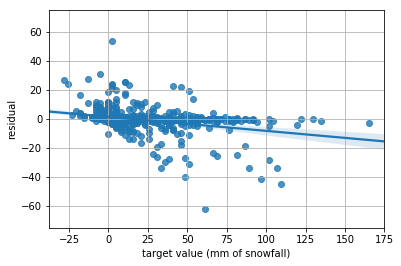

1.26240923589
8.45695171906


In [100]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

#from sklearn.linear_model import Ridge, RidgeCV, LassoCV, Lasso, ElasticNetCV

xgbr = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=80,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=2, reg_lambda=2, scale_pos_weight=0.001, seed=None,
       silent=False, subsample=0.9)

# xgbr = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
#        max_depth=4, min_child_weight=1, missing=None, n_estimators=90,
#        n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
#        reg_alpha=8, reg_lambda=16, scale_pos_weight=1, seed=None,
#        silent=True, subsample=0.7)

pipeline = [
    ('poly', PolynomialFeatures(3)),
    ('estimator', xgbr)
    #('estimator', Ridge(alpha_fits[1]))
    #('estimator', ElasticNet(alpha_fits[2]))
]

pipeline = Pipeline(pipeline)
pipeline.fit(X_train, y_train)
y_predict = pipeline.predict(X)

X_final = df_mean.copy()
X_final['predicted_mm'] = y_predict
X_final.to_pickle('xgb_results_meltoff.pkl')
X = df_mean.drop(['day_id','expected_mm', 'time_until_reading'], axis=1)
y = df_mean['expected_mm']
sns.regplot(X_final['expected_mm'], X_final['predicted_mm']-X_final['expected_mm'],'.')
plt.ylabel('residual')
plt.xlabel('target value (mm of snowfall)')
plt.ylim(-75, 75) 
plt.grid()
plt.show()

# mae
y_predict_train = pipeline.predict(X_train)
y_predict_test = pipeline.predict(X_test)
print(mean_absolute_error(y_train,y_predict_train))
print(mean_absolute_error(y_test,y_predict_test))

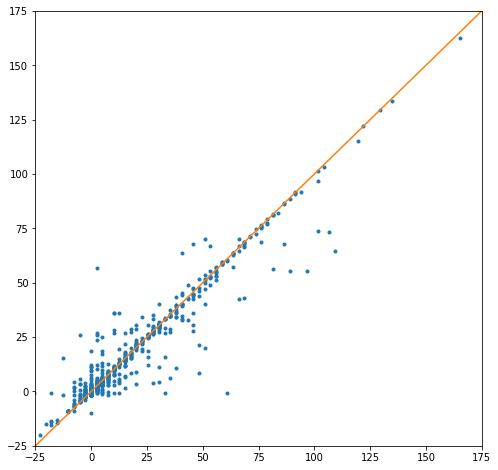

In [102]:
plt.figure(figsize=(8,8))
plt.plot(y,y_predict,'.')
plt.plot([-25,175],[-25,175])
plt.xlim(-25,175)

plt.ylim(-25,175)
plt.show()

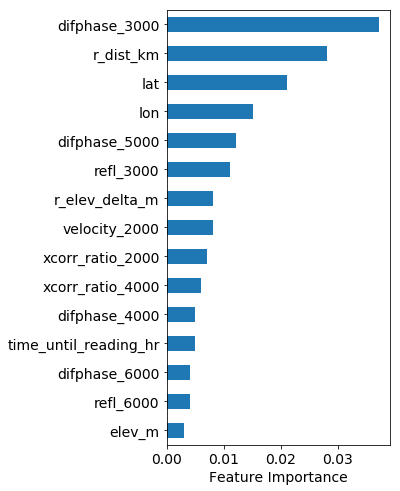

In [103]:
fi_dict = {a[0]:a[1] for a in zip(list(X.columns), list(xgbr.feature_importances_))}
features_importance = pd.DataFrame.from_dict(fi_dict, orient='index')

fi = features_importance.sort_values(by=[0], ascending=True)
fi.iloc[-15:].plot.barh(stacked=True, legend=False, figsize = (4,8), fontsize = 14)
plt.xlabel('Feature Importance', fontsize=14)
plt.savefig('foo.pdf', bbox_inches='tight')
plt.show()